<a href="https://colab.research.google.com/github/bleamer/eva5/blob/master/w10-AdvanceTraining/w10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
current_path = '/content/drive/My Drive/eva5/w10-AdvanceTraining/' 
os.chdir(current_path)

In [4]:
!ls

Accuracies.png	__init__.py  output    README.md  utils     w9_Quiz.ipynb
dataset		model	     postproc  req.txt	  w9.ipynb


In [5]:
!pip install -q -r req.txt

In [6]:
import torch                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
import torchvision
import torchvision.transforms as transforms

from model.train import train
from model.cnn import Net
from model.resnet import ResNet18
from model.eval import val
from model.utils import cuda_init, cross_entropy_loss, sgd_optimizer, model_summary

from dataset.dataset import DS_Cifar10
from dataset.download import download_cifar10

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from model.tools import LRFinder


### Init Device

In [7]:
RAND_VAL = 42

TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
NUM_WORKER = 64

In [8]:
cuda, dev = cuda_init(RAND_VAL)
print(cuda, dev)

True cuda


In [9]:
!nvidia-smi --query-gpu=timestamp,gpu_name,utilization.gpu,utilization.memory --format=csv

timestamp, name, utilization.gpu [%], utilization.memory [%]
2020/10/09 05:00:54.698, Tesla T4, 0 %, 0 %


### Fetch and Check the data

In [10]:
hflip = 0.2
vflip = 0.1
rotation = 12.0
cutout=0.3
cutout_dimen = (10,10)

In [11]:
DS = DS_Cifar10(path='/tmp', hflip = hflip, vflip = vflip,rotation = rotation, cutout=cutout, cutout_dimen=cutout_dimen)
Classes = DS.classes

path /tmp
Files already downloaded and verified
Transformations
{'path': '/tmp', 'hflip': 0.2, 'vflip': 0.1, 'rotation': 12.0, 'cutout': 0.3, 'cutout_dimen': (10, 10)}
path /tmp
Files already downloaded and verified
Transformations
{'train': False, 'path': '/tmp', 'hflip': 0.2, 'vflip': 0.1, 'rotation': 12.0, 'cutout': 0.3, 'cutout_dimen': (10, 10)}
path /tmp
Files already downloaded and verified


### Data Loaders

In [12]:
train_loader = DS.loader(batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKER, cuda=cuda)
test_loader = DS.loader(train = False, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKER, cuda=cuda)

{'batch_size': 64, 'num_workers': 64, 'cuda': True}
train True
{'train': False, 'batch_size': 64, 'num_workers': 64, 'cuda': True}
train False


In [13]:
DROPOUT = 0.1
# model = Net(DROPOUT).to(dev)
model = ResNet18().to(dev)

In [14]:
image_size = DS.image_size
model_summary(model, image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.28E-01


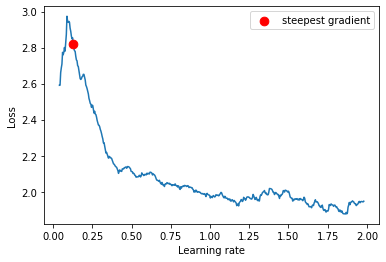

In [15]:
import torch.optim as optim

EPOCHS = 50
LEARNING_RATE = 0.01
MOMENTUM = 0.9
SAMPLE_COUNT = 25
START_LR = 1E-7
END_LR = 2
NUM_ITER = 500
MIN_LR = 1E-4
LR_DECAY_FACTOR = 0.1
LR_DECAY_PATIENCE = 2

TARGET_ACCURACY = 88+1

criterion = cross_entropy_loss()  # Create loss function

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
lr_finder = LRFinder(model, optimizer, criterion, device=dev)
lr_finder.range_test(train_loader,start_lr=MIN_LR, end_lr=END_LR, num_iter=NUM_ITER, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

In [16]:
print(lr_finder.get_best_lr())
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.12835010020040077
0.01


In [17]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau




losses = []
train_accuracies = []
accuracies = []
incorrect_samples = []
correct_samples = []


optimizer = optim.SGD(model.parameters(), lr= lr_finder.get_best_lr(), momentum=MOMENTUM)
for param_group in optimizer.param_groups:
    print('Starting Learning rate:',str(param_group['lr']))
# scheduler = StepLR(optimizer, step_size=10, gamma=0.3)
scheduler = ReduceLROnPlateau(optimizer, factor=LR_DECAY_FACTOR, 
                              patience=LR_DECAY_PATIENCE, verbose=True, min_lr=MIN_LR
    )


for epoch in tqdm(range(1, EPOCHS + 1)):
    print(f'Epoch {epoch}:')
    train(model, train_loader, dev, optimizer, criterion, accuracy_hist = train_accuracies)

    val(
        model, test_loader, dev, criterion, losses, accuracies,
        correct_samples, incorrect_samples, SAMPLE_COUNT, epoch,EPOCHS
    )
    scheduler.step(losses[-1])
    if accuracies[-1] > TARGET_ACCURACY:
      break

  0%|          | 0/50 [00:00<?, ?it/s]

Starting Learning rate: 0.12835010020040077
Epoch 1:


  2%|▏         | 1/50 [01:25<1:09:42, 85.36s/it]


Validation set: Average loss: 0.0243, Accuracy: 4399/10000 (43.99%)

Epoch 2:


  4%|▍         | 2/50 [02:50<1:08:21, 85.44s/it]


Validation set: Average loss: 0.0202, Accuracy: 5282/10000 (52.82%)

Epoch 3:


  6%|▌         | 3/50 [04:16<1:06:59, 85.53s/it]


Validation set: Average loss: 0.0164, Accuracy: 6269/10000 (62.69%)

Epoch 4:


  8%|▊         | 4/50 [05:42<1:05:42, 85.72s/it]


Validation set: Average loss: 0.0157, Accuracy: 6539/10000 (65.39%)

Epoch 5:


 10%|█         | 5/50 [07:08<1:04:20, 85.80s/it]


Validation set: Average loss: 0.0123, Accuracy: 7242/10000 (72.42%)

Epoch 6:


 12%|█▏        | 6/50 [08:34<1:02:56, 85.82s/it]


Validation set: Average loss: 0.0115, Accuracy: 7444/10000 (74.44%)

Epoch 7:


 14%|█▍        | 7/50 [10:00<1:01:32, 85.87s/it]


Validation set: Average loss: 0.0109, Accuracy: 7592/10000 (75.92%)

Epoch 8:


 16%|█▌        | 8/50 [11:26<1:00:06, 85.87s/it]


Validation set: Average loss: 0.0113, Accuracy: 7592/10000 (75.92%)

Epoch 9:


 18%|█▊        | 9/50 [12:52<58:40, 85.87s/it]  


Validation set: Average loss: 0.0106, Accuracy: 7828/10000 (78.28%)

Epoch 10:


 20%|██        | 10/50 [14:18<57:14, 85.87s/it]


Validation set: Average loss: 0.0103, Accuracy: 7949/10000 (79.49%)

Epoch 11:


 22%|██▏       | 11/50 [15:44<55:51, 85.92s/it]


Validation set: Average loss: 0.0109, Accuracy: 7912/10000 (79.12%)

Epoch 12:


 24%|██▍       | 12/50 [17:10<54:27, 85.98s/it]


Validation set: Average loss: 0.0110, Accuracy: 7942/10000 (79.42%)

Epoch 13:


 26%|██▌       | 13/50 [18:36<52:58, 85.92s/it]


Validation set: Average loss: 0.0106, Accuracy: 8057/10000 (80.57%)

Epoch    13: reducing learning rate of group 0 to 1.2835e-02.
Epoch 14:


 28%|██▊       | 14/50 [20:02<51:32, 85.91s/it]


Validation set: Average loss: 0.0094, Accuracy: 8345/10000 (83.45%)

Epoch 15:


 30%|███       | 15/50 [21:27<50:04, 85.85s/it]


Validation set: Average loss: 0.0095, Accuracy: 8389/10000 (83.89%)

Epoch 16:


 32%|███▏      | 16/50 [22:53<48:38, 85.84s/it]


Validation set: Average loss: 0.0098, Accuracy: 8408/10000 (84.08%)

Epoch 17:


 34%|███▍      | 17/50 [24:19<47:12, 85.84s/it]


Validation set: Average loss: 0.0100, Accuracy: 8388/10000 (83.88%)

Epoch    17: reducing learning rate of group 0 to 1.2835e-03.
Epoch 18:


 36%|███▌      | 18/50 [25:45<45:45, 85.79s/it]


Validation set: Average loss: 0.0101, Accuracy: 8392/10000 (83.92%)

Epoch 19:


 38%|███▊      | 19/50 [27:11<44:20, 85.81s/it]


Validation set: Average loss: 0.0100, Accuracy: 8403/10000 (84.03%)

Epoch 20:


 40%|████      | 20/50 [28:36<42:53, 85.79s/it]


Validation set: Average loss: 0.0100, Accuracy: 8413/10000 (84.13%)

Epoch    20: reducing learning rate of group 0 to 1.2835e-04.
Epoch 21:


 42%|████▏     | 21/50 [30:02<41:27, 85.77s/it]


Validation set: Average loss: 0.0100, Accuracy: 8417/10000 (84.17%)

Epoch 22:


 44%|████▍     | 22/50 [31:28<40:02, 85.81s/it]


Validation set: Average loss: 0.0099, Accuracy: 8422/10000 (84.22%)

Epoch 23:


 46%|████▌     | 23/50 [32:54<38:38, 85.88s/it]


Validation set: Average loss: 0.0100, Accuracy: 8397/10000 (83.97%)

Epoch    23: reducing learning rate of group 0 to 1.0000e-04.
Epoch 24:


 48%|████▊     | 24/50 [34:20<37:11, 85.81s/it]


Validation set: Average loss: 0.0099, Accuracy: 8407/10000 (84.07%)

Epoch 25:


 50%|█████     | 25/50 [35:44<35:37, 85.51s/it]


Validation set: Average loss: 0.0100, Accuracy: 8399/10000 (83.99%)

Epoch 26:


 52%|█████▏    | 26/50 [37:09<34:08, 85.37s/it]


Validation set: Average loss: 0.0099, Accuracy: 8413/10000 (84.13%)

Epoch 27:


 54%|█████▍    | 27/50 [38:34<32:39, 85.20s/it]


Validation set: Average loss: 0.0099, Accuracy: 8409/10000 (84.09%)

Epoch 28:


 56%|█████▌    | 28/50 [40:00<31:14, 85.22s/it]


Validation set: Average loss: 0.0099, Accuracy: 8405/10000 (84.05%)

Epoch 29:


 58%|█████▊    | 29/50 [41:24<29:46, 85.06s/it]


Validation set: Average loss: 0.0099, Accuracy: 8396/10000 (83.96%)

Epoch 30:


 60%|██████    | 30/50 [42:49<28:18, 84.90s/it]


Validation set: Average loss: 0.0101, Accuracy: 8398/10000 (83.98%)

Epoch 31:


 62%|██████▏   | 31/50 [44:13<26:51, 84.82s/it]


Validation set: Average loss: 0.0100, Accuracy: 8403/10000 (84.03%)

Epoch 32:


 64%|██████▍   | 32/50 [45:38<25:25, 84.76s/it]


Validation set: Average loss: 0.0099, Accuracy: 8422/10000 (84.22%)

Epoch 33:


 66%|██████▌   | 33/50 [47:03<24:00, 84.76s/it]


Validation set: Average loss: 0.0100, Accuracy: 8405/10000 (84.05%)

Epoch 34:


 68%|██████▊   | 34/50 [48:28<22:38, 84.94s/it]


Validation set: Average loss: 0.0098, Accuracy: 8408/10000 (84.08%)

Epoch 35:


 70%|███████   | 35/50 [49:53<21:13, 84.87s/it]


Validation set: Average loss: 0.0099, Accuracy: 8436/10000 (84.36%)

Epoch 36:


 72%|███████▏  | 36/50 [51:19<19:51, 85.11s/it]


Validation set: Average loss: 0.0098, Accuracy: 8417/10000 (84.17%)

Epoch 37:


 74%|███████▍  | 37/50 [52:44<18:26, 85.08s/it]


Validation set: Average loss: 0.0099, Accuracy: 8408/10000 (84.08%)

Epoch 38:


 76%|███████▌  | 38/50 [54:08<17:00, 85.03s/it]


Validation set: Average loss: 0.0100, Accuracy: 8413/10000 (84.13%)

Epoch 39:


 78%|███████▊  | 39/50 [55:33<15:34, 84.99s/it]


Validation set: Average loss: 0.0099, Accuracy: 8427/10000 (84.27%)

Epoch 40:


 80%|████████  | 40/50 [56:59<14:10, 85.04s/it]


Validation set: Average loss: 0.0100, Accuracy: 8410/10000 (84.10%)

Epoch 41:


 82%|████████▏ | 41/50 [58:23<12:44, 84.96s/it]


Validation set: Average loss: 0.0100, Accuracy: 8422/10000 (84.22%)

Epoch 42:


 84%|████████▍ | 42/50 [59:48<11:20, 85.00s/it]


Validation set: Average loss: 0.0099, Accuracy: 8416/10000 (84.16%)

Epoch 43:


 86%|████████▌ | 43/50 [1:01:13<09:55, 85.03s/it]


Validation set: Average loss: 0.0100, Accuracy: 8416/10000 (84.16%)

Epoch 44:


 88%|████████▊ | 44/50 [1:02:38<08:29, 84.96s/it]


Validation set: Average loss: 0.0100, Accuracy: 8421/10000 (84.21%)

Epoch 45:


 90%|█████████ | 45/50 [1:04:03<07:04, 84.92s/it]


Validation set: Average loss: 0.0099, Accuracy: 8425/10000 (84.25%)

Epoch 46:


 92%|█████████▏| 46/50 [1:05:28<05:39, 84.82s/it]


Validation set: Average loss: 0.0100, Accuracy: 8405/10000 (84.05%)

Epoch 47:


 94%|█████████▍| 47/50 [1:06:52<04:14, 84.77s/it]


Validation set: Average loss: 0.0098, Accuracy: 8423/10000 (84.23%)

Epoch 48:


 96%|█████████▌| 48/50 [1:08:17<02:49, 84.78s/it]


Validation set: Average loss: 0.0098, Accuracy: 8418/10000 (84.18%)

Epoch 49:


 98%|█████████▊| 49/50 [1:09:42<01:24, 84.91s/it]


Validation set: Average loss: 0.0101, Accuracy: 8415/10000 (84.15%)

Epoch 50:


100%|██████████| 50/50 [1:11:09<00:00, 85.39s/it]


Validation set: Average loss: 0.0100, Accuracy: 8407/10000 (84.07%)



In [18]:
train_accuracies

[31.704,
 48.182,
 57.52,
 64.868,
 70.564,
 74.528,
 78.284,
 81.488,
 84.61,
 86.948,
 89.21,
 91.112,
 92.73,
 96.76,
 97.842,
 98.268,
 98.55,
 98.824,
 98.822,
 98.76,
 98.734,
 98.834,
 98.806,
 98.808,
 98.802,
 98.86,
 98.768,
 98.816,
 98.902,
 98.756,
 98.86,
 98.828,
 98.824,
 98.86,
 98.834,
 98.858,
 98.788,
 98.734,
 98.774,
 98.81,
 98.846,
 98.836,
 98.802,
 98.876,
 98.876,
 98.846,
 98.832,
 98.756,
 98.864,
 98.878]

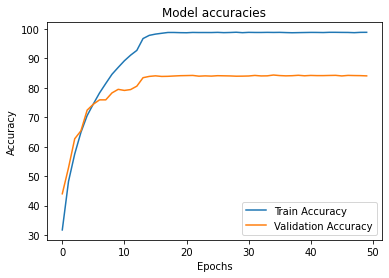

In [19]:
fig, ax = plt.subplots()
ax.plot(train_accuracies)
ax.plot(accuracies)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Model accuracies')
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.savefig('Accuracies.png')
plt.show()

In [20]:
import random
# importlib.reload(gradcam)

from postproc.gradcam import GradCAMOverlay

grad_cam = GradCAMOverlay(
    model, ['layer_4'],
    dev, DS.mean, DS.std
)



intent layer 4
intent layer 4
Mode set to GradCAM.


In [21]:
from pathlib import Path
Path(current_path+'/output').mkdir(parents=True, exist_ok=True)


### GradCAM Negative Images

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


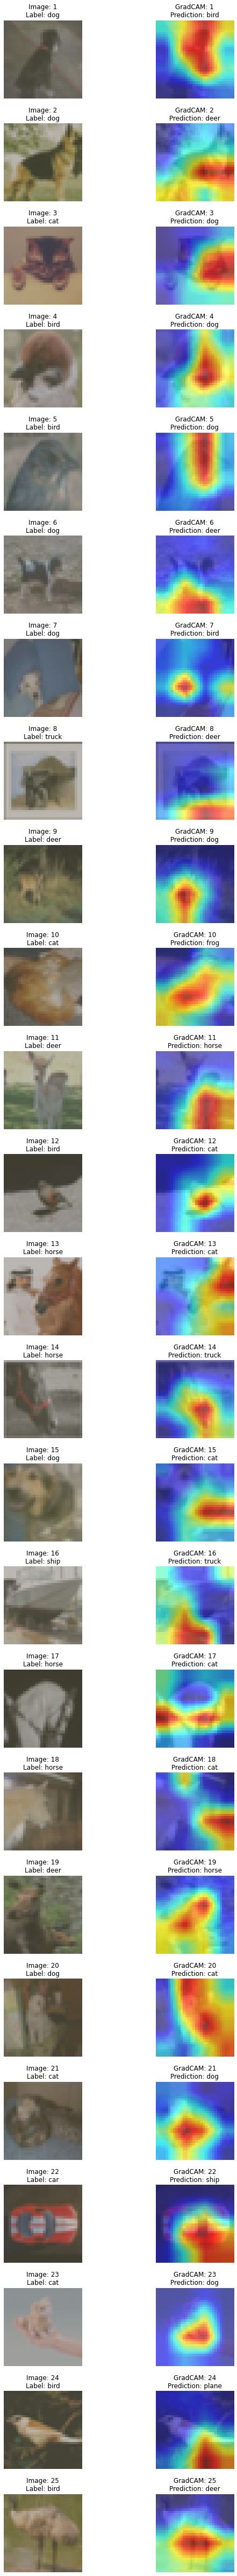

In [22]:
# incorrect_im_prefix = 'Incorrect_grad_cam'
incorrect_images = [x['image'] for x in random.sample(incorrect_samples, 25)]
# grad_cam(incorrect_images,current_path+'/output/'+incorrect_im_prefix)

gc_im = grad_cam([x['image'] for x in incorrect_samples])

fig, ax = plt.subplots(len(incorrect_images), 2, figsize=(10, 60))
for i in range(len(incorrect_images)):
  label = DS.classes[incorrect_samples[i]['label']]
  prediction = DS.classes[incorrect_samples[i]['prediction']]

  ax[i][0].axis('off')
  ax[i][0].set_title(f'Image: {i + 1}\nLabel: {label}')
  ax[i][0].imshow(gc_im[i]['image'])

  ax[i][1].axis('off')
  ax[i][1].set_title(f'GradCAM: {i + 1}\nPrediction: {prediction}')
  ax[i][1].imshow(gc_im[i]['result']['layer_4'])

fig.tight_layout()
fig.subplots_adjust(top=1.1)
fig.savefig(current_path+'/output/failediamges.png', bbox_inches='tight')

In [23]:
total_params = sum(param.numel() for name, param in  model.named_parameters())


In [24]:
readme = f'''

# 10 - Advanced Training

## Used LRFinder and Reduce LR on Plateau Optimizer

This notebook implements CIFAR10 classification using ResNet NN architecture using PyTorch,
and uses GradCAM analysis for model explanation  to explain which layer of model was activated for the give image

Here we use Data Augmentation implementusing [Albumentations](https://github.com/albumentations-team/albumentations) library

The results with using ResNet18 architecture with (2,2,2,2), that is, 4 residual blocks of size 2 each.
 
----
| Attribute | Value |
|:--- | :--- |
| Train Accuracy | {np.max(train_accuracies)} |
| Test Accuracy | {np.max(accuracies)} |
| Trained Parameter count   |{total_params} |
| Dropout | {DROPOUT} |
| Total Epochs | {EPOCHS} |
| Batch Size | {TRAIN_BATCH_SIZE}|
| LR using LRFinder | {lr_finder.get_best_lr():.4f}|


----

![](Accuracies.png)

The model uses:
* 3x3 Convolution
* Batch Normalization
* Max Pooling
* 4 X Residual networks of size 2 

To run 

You can install dependencies using  
`$ pip install -r req.txt`


###Grad CAM Images
![](output/failediamges.png)

'''

with open('README.md', 'w') as f:
    f.write(readme)